# Fraud Detection

This fraud detection project is to identify is based on #link.
The data used here is a simulated one as it's difficult to get a real world data in this domain due to data protection policies. The data consists of unique transaction id, date and time, customer id, terminal id, transaction amount and fraud or not(the prediction variable)

###### The approach
- Based on the data, we first crete new meaningful features 
- Create train and test data
- Create base line model and evalute
- Tuning of models
- Try complex models

In [19]:
%run shared_functions.py


In [22]:
#DIR_INPUT='./simulated-data-raw/data/' 
DIR_INPUT = '/Users/padmac/Documents/UPGRAD/My_work/Creditcard_fraud_detection/simulated-data-raw-main/data'
BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


Load  files
CPU times: user 2.8 s, sys: 522 ms, total: 3.32 s
Wall time: 3.34 s
1754155 transactions loaded, containing 14681 fraudulent transactions


In [25]:
transactions_df.shape

(1754155, 9)

In [26]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [27]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        int64         
 3   TERMINAL_ID        int64         
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    int64         
 6   TX_TIME_DAYS       int64         
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 120.4 MB


### Create new features

##### Based on time of transaction
-  Whether tx happened during day or night
-  Whether tx happend in weekday or weekend


In [28]:
def is_weekend(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

In [29]:
%time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)


CPU times: user 7.88 s, sys: 163 ms, total: 8.04 s
Wall time: 8.07 s


In [34]:
def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    
    return int(is_night)

In [35]:
%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)


CPU times: user 7.91 s, sys: 124 ms, total: 8.03 s
Wall time: 8.04 s


In [36]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,1,1
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,1,1
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,1,1
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,1,1
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,1,1


##### Based on customer id
- We will create new features based on RFM (Recency, Frequency, Monetary value) framework
- The first feature will be the number of transactions that occur within a time window (Frequency). The second will be the average amount spent in these transactions (Monetary value). The time windows will be set to one, seven, and thirty days.

In [38]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions

In [40]:
# Get customer behaviour for customer id 0
spending_behaviour_customer_0 = get_customer_spending_behaviour_features(transactions_df[transactions_df.CUSTOMER_ID==0])
spending_behaviour_customer_0


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,,
1758,1758,2018-04-01 07:19:05,0,6076,123.59,26345,0,0,0,1,0,1.0,123.590000,1.0,123.590000,1.0,123.590000
8275,8275,2018-04-01 18:00:16,0,858,77.34,64816,0,0,0,1,0,2.0,100.465000,2.0,100.465000,2.0,100.465000
8640,8640,2018-04-01 19:02:02,0,6698,46.51,68522,0,0,0,1,0,3.0,82.480000,3.0,82.480000,3.0,82.480000
12169,12169,2018-04-02 08:51:06,0,6569,54.72,118266,1,0,0,0,0,3.0,59.523333,4.0,75.540000,4.0,75.540000
15764,15764,2018-04-02 14:05:38,0,7707,63.30,137138,1,0,0,0,0,4.0,60.467500,5.0,73.092000,5.0,73.092000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750390,1750390,2018-09-30 13:38:41,0,3096,38.23,15773921,182,0,0,1,0,5.0,64.388000,28.0,57.306429,89.0,63.097640
1750758,1750758,2018-09-30 14:10:21,0,9441,43.60,15775821,182,0,0,1,0,6.0,60.923333,29.0,56.833793,89.0,62.433933
1751039,1751039,2018-09-30 14:34:30,0,1138,69.69,15777270,182,0,0,1,0,7.0,62.175714,29.0,57.872414,90.0,62.514556


In [41]:
#Let us now generate these features for all customers. 

%time transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)


CPU times: user 37.4 s, sys: 665 ms, total: 38 s
Wall time: 38.2 s


In [42]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,1,1,1.0,57.16,1.0,57.16,1.0,57.16
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,1,1,1.0,81.51,1.0,81.51,1.0,81.51
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,1,1,1.0,146.00,1.0,146.00,1.0,146.00
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,1,1,1.0,64.49,1.0,64.49,1.0,64.49
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,1,1,1.0,50.99,1.0,50.99,1.0,50.99


#### Based on terminal id
 The main goal will be to extract a risk score, that assesses the exposure of a given terminal ID to fraudulent transactions. The risk score will be defined as the average number of fraudulent transactions that occurred on a terminal ID over a time window. As for customer ID transformations, we will use three window sizes, of 1, 7, and 30 days.
 
  Contrary to customer ID transformations, the time windows will not directly precede a given transaction. Instead, they will be shifted back by a delay period. The delay period accounts for the fact that, in practice, the fraudulent transactions are only discovered after a fraud investigation or a customer complaint. Hence, the fraudulent labels, which are needed to compute the risk score, are only available after this delay period. This delay period will be set to one week as an approximate.

In [43]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    #sort values by tx time
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    #set datetime as index for rolling calculations
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    #Calculate the number of fraud transactions and total transactions of a terminal for last 7 days
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    #Calculate the number of fraud transactions and total transactions of a terminal for 3 window sizes with added dealy period

    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
        
        # Actual txs calculated by subtracting delay values from window values(delay added window)
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        # Risk calculation for a terminal for a given window
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    # Change index back to ix id
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

In [44]:
transactions_df[transactions_df.TX_FRAUD==1]


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
3527,3527,2018-04-01 10:17:43,3774,3059,225.41,37063,0,1,1,1,0,3.0,158.073333,3.0,158.073333,3.0,158.073333
5789,5790,2018-04-01 13:31:48,4944,6050,222.26,48708,0,1,1,1,0,2.0,127.605000,2.0,127.605000,2.0,127.605000
6549,6549,2018-04-01 14:42:02,4625,9102,226.40,52922,0,1,1,1,0,4.0,167.165000,4.0,167.165000,4.0,167.165000
9583,9583,2018-04-02 01:01:05,3814,6893,59.15,90065,1,1,3,0,1,6.0,29.138333,6.0,29.138333,6.0,29.138333
10356,10355,2018-04-02 05:03:35,2513,1143,222.04,104615,1,1,1,0,1,5.0,123.740000,5.0,123.740000,5.0,123.740000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753524,1753524,2018-09-30 19:51:48,1671,3192,128.60,15796308,182,1,3,1,0,6.0,138.358333,25.0,106.957200,82.0,75.621341
1753600,1753600,2018-09-30 20:09:00,4166,632,17.39,15797340,182,1,2,1,0,3.0,19.766667,19.0,15.984737,86.0,15.846512
1753673,1753673,2018-09-30 20:30:52,4097,1558,24.04,15798652,182,1,2,1,0,3.0,23.050000,16.0,40.440625,63.0,41.877460
1754014,1754014,2018-09-30 22:27:04,100,8604,73.85,15805624,182,1,3,1,0,2.0,48.010000,26.0,30.384231,103.0,23.627184


In [49]:
(get_count_risk_rolling_window(transactions_df[transactions_df.TERMINAL_ID==3059], delay_period=7, windows_size_in_days=[1,7,30])).head(20)


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,,,
3527,3527,2018-04-01 10:17:43,3774,3059,225.41,37063,0,1,1,1,...,3.0,158.073333,3.0,158.073333,0.0,0.0,0.0,0.000000,0.0,0.000000
4732,4732,2018-04-01 11:59:14,55,3059,36.28,43154,0,0,0,1,...,2.0,35.670000,2.0,35.670000,0.0,0.0,0.0,0.000000,0.0,0.000000
16216,16216,2018-04-02 14:47:34,4879,3059,105.00,139654,1,0,0,0,...,10.0,76.010000,10.0,76.010000,0.0,0.0,0.0,0.000000,0.0,0.000000
18249,18249,2018-04-02 19:08:10,2263,3059,90.89,155290,1,0,0,0,...,7.0,50.458571,7.0,50.458571,0.0,0.0,0.0,0.000000,0.0,0.000000
26512,26512,2018-04-03 15:44:49,4879,3059,58.51,229489,2,0,0,0,...,14.0,71.070000,14.0,71.070000,0.0,0.0,0.0,0.000000,0.0,0.000000
29143,29143,2018-04-04 02:47:50,380,3059,14.86,269270,3,0,0,0,...,10.0,47.571000,10.0,47.571000,0.0,0.0,0.0,0.000000,0.0,0.000000
31121,31121,2018-04-04 08:14:29,2508,3059,20.44,288869,3,0,0,0,...,6.0,34.176667,6.0,34.176667,0.0,0.0,0.0,0.000000,0.0,0.000000
32815,32815,2018-04-04 10:49:58,1783,3059,13.04,298198,3,0,0,0,...,14.0,81.404286,14.0,81.404286,0.0,0.0,0.0,0.000000,0.0,0.000000
43721,43721,2018-04-05 12:39:28,1769,3059,48.79,391168,4,0,0,0,...,11.0,77.927273,11.0,77.927273,0.0,0.0,0.0,0.000000,0.0,0.000000


In [50]:
%time transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)


CPU times: user 1min 35s, sys: 851 ms, total: 1min 36s
Wall time: 1min 36s


In [51]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,1,...,1.0,57.16,1.0,57.16,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,1,...,1.0,81.51,1.0,81.51,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,1,...,1.0,146.00,1.0,146.00,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,1,...,1.0,64.49,1.0,64.49,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,1,...,1.0,50.99,1.0,50.99,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
#Store transformed data
DIR_OUTPUT = "./simulated-data-transformed/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

In [94]:
transactions_df.to_csv('transactions.csv')

# Modeling

#### Creating train and test set
For creating a baseline model, we will use data from 2018-07-25 to the 2018-07-31 for the training set, and from the 2018-08-08 to the 2018-08-14 for the test set. There is a gap of 1 week between the train and test set. It accounts for the fact that, in a real-world fraud detection system, the label of a transaction (fraudulent or genuine) is only known after a customer complaint, or after a fraud investigation. Therefore, in a realistic scenario, the annotated data available to train a model and start making predictions for a given day are anterior to that day minus the delay period

Two weeks data will be used to create a baseline model.

In [86]:
transactions_seldf = transactions_df.loc[(transactions_df.TX_DATETIME >= '2018-07-25') & (transactions_df.TX_DATETIME <= '2018-08-14')].copy() 


In [87]:
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_seldf),transactions_seldf.TX_FRAUD.sum()))


191731 transactions loaded, containing 1714 fraudulent transactions


In [135]:
# Compute the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_tx_stats(transactions_df, start_date_df="2018-04-01"):
    
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraudulent_transactions_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of compromised cards per day
    nb_compromised_cards_per_day=transactions_df[transactions_df['TX_FRAUD']==1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    tx_stats=pd.DataFrame({"nb_tx_per_day":nb_tx_per_day,
                           "nb_fraudulent_transactions_per_day":nb_fraudulent_transactions_per_day,
                           "nb_compromised_cards_per_day":nb_compromised_cards_per_day})

    tx_stats=tx_stats.reset_index()
    
    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)
    
    tx_stats['tx_date']=tx_date
    
    return tx_stats

tx_stats=get_tx_stats(transactions_seldf, start_date_df="2018-04-01")


In [137]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_template_tx_stats(ax ,fs,
                          start_date_training,
                          title='',
                          delta_train=7,
                          delta_delay=7,
                          delta_test=7,
                          ylim=300):
    
    ax.set_title(title, fontsize=fs*1.5)
    ax.set_ylim([0, ylim])
    
    ax.set_xlabel('Date', fontsize=fs)
    ax.set_ylabel('Number', fontsize=fs)
    
    plt.yticks(fontsize=fs*0.7) 
    plt.xticks(fontsize=fs*0.7)    

    ax.axvline(start_date_training+datetime.timedelta(days=delta_train), 0,ylim, color="black")
    ax.axvline(start_date_test, 0, ylim, color="black")
    
    ax.text(start_date_training+datetime.timedelta(days=2), ylim-20,'Training period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+2), ylim-20,'Delay period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+delta_delay+2), ylim-20,'Test period', fontsize=fs)


cmap = plt.get_cmap('jet')
colors={'nb_tx_per_day':cmap(0), 
        'nb_fraudulent_transactions_per_day':cmap(200), 
        'nb_compromised_cards_per_day':cmap(250)}

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Total transactions, and number of fraudulent transactions \n and number of compromised cards per day',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
ax.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day'], 'b', color=colors['nb_compromised_cards_per_day'], label = '# compromised cards per day')

ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)

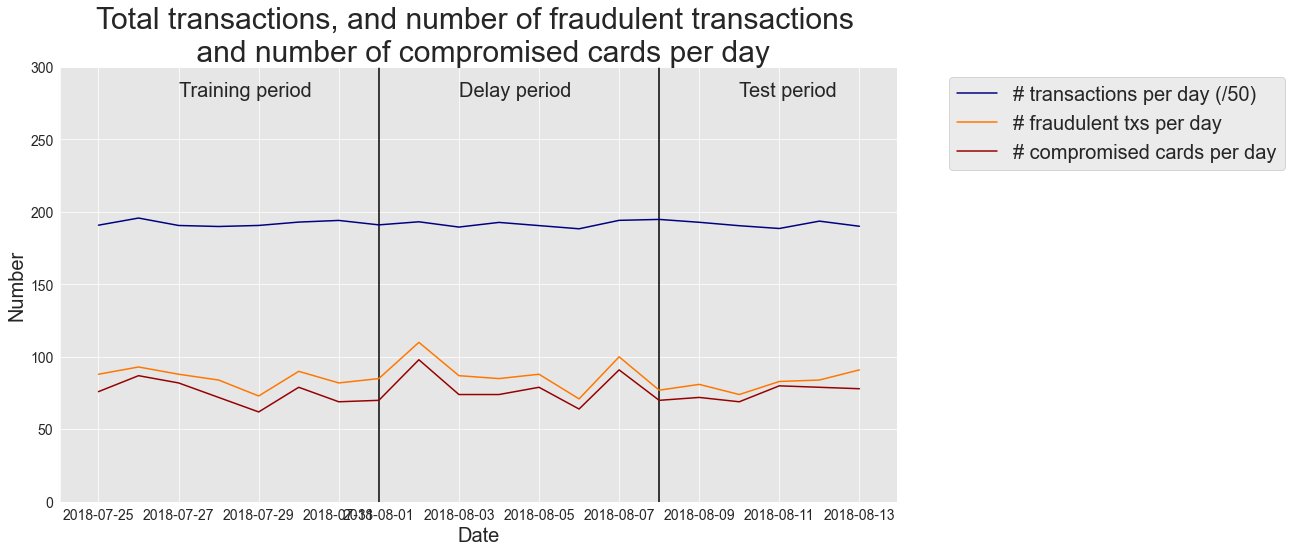

In [138]:
fraud_and_transactions_stats_fig

The plot illustrates that the number of transactions and frauds is similar in the training and test periods. The average number of frauds is around 85 per day. Let us extract from the dataset the transactions for the training set and the test set.

In [161]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        #115+7+-1,1
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

In [167]:
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

In [163]:
train_df.shape

(67240, 23)

In [168]:
train_df[train_df.TX_FRAUD==1]['TX_FRAUD'].sum()

598

In [169]:
test_df.shape

(58264, 23)

In [170]:
test_df[test_df.TX_FRAUD==1]['TX_FRAUD'].sum()

385

The trainig set contains 67240 transactions, among which 598 are fraudulent. The test set contains 58264 transactions, among which 385 are fraudulent.



In [171]:
598/67240

0.008893515764425937

That is, a proportion of 0.008 fraudulent transactions.



## Modelling
- Create base line modelling using DecisionTree

In [172]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

In [174]:
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                  input_features, output_feature="TX_FRAUD",scale=True):

    # By default, scales input data
    if scale:
        (train_df, test_df)=scaleData(train_df,test_df,input_features)
    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

In [175]:
# We first create a decision tree object. We will limit its depth to 2 for interpretability, 
# and set the random state to zero for reproducibility
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=False)

In [176]:
test_df['TX_FRAUD_PREDICTED']=model_and_predictions_dictionary['predictions_test']
test_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED
1236698,1236698,2018-08-08 00:01:14,2765,2747,42.32,11145674,129,0,0,0,...,67.468529,120.0,64.611750,2.0,0.0,9.0,0.0,31.0,0.000000,0.003536
1236699,1236699,2018-08-08 00:02:33,714,2073,108.19,11145753,129,0,0,0,...,79.955455,124.0,85.365645,2.0,0.0,10.0,0.0,23.0,0.000000,0.003536
1236701,1236701,2018-08-08 00:08:40,4982,1258,26.13,11146120,129,0,0,0,...,56.269167,61.0,49.095902,1.0,0.0,10.0,0.0,26.0,0.076923,0.003536
1236702,1236702,2018-08-08 00:08:41,704,8501,65.81,11146121,129,0,0,0,...,62.643333,11.0,63.287273,1.0,0.0,6.0,0.0,23.0,0.000000,0.003536
1236703,1236703,2018-08-08 00:10:34,3085,4208,55.22,11146234,129,0,0,0,...,71.993846,72.0,59.899306,1.0,0.0,5.0,0.0,21.0,0.523810,0.003536


All transactions displayed above has a predicted probbaility of 0.0035

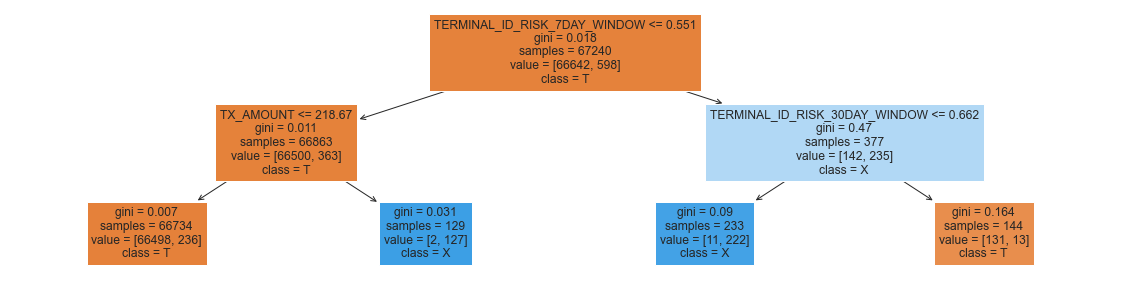

In [191]:
#Explain decisiontree
from sklearn import tree
fig = plt.figure(figsize=(20,5))
_= tree.plot_tree(classifier,
                   feature_names=input_features,  
                   class_names=output_feature,
                   filled=True)

# Evaluation metrics

We will use below 3 metrices for the fraud detection evaluation
###### 1. Precision top-k metrics
The main intention of a fraud detection system is to give alerts to investigators on transactions. Then these transactions are manually checked by contacting cardholders. As this is a time consuming process the number of alerts that may be checked during a given period is therefore necessarily limited.
 
 Precision top-k metrics aim at quantifying the performance of an FDS in this setting. Precisions are computed daily, reflecting the precisions obtained for a working day of fraud investigators. The  parameter quantifies the maximum number of alerts that can be checked by investigators in a day. Here we assume 100 as the value for k.

The P@k(d) can be computed for a day  by ranking all fraud probabilities by decreasing order, and computing the precision for the top  ranked transactions. 
###### 2. The Average Precision 
The Average Precision integrates precisions for all possible  values. Average Precision (AP) summarizes Precision-Recall plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. 
 
 The performance of a random classifier depends on the class imbalance. It is 0.5 in the balanced case, and P/(P+N) in the general case, where P is the number of positive examples, and N the number of negative examples. In particular, a classifier that classifies all examples as positive (recall of 1) has a precision of P/(P+N). This property makes the AP more interesting than the AUC ROC in a fraud detection problem, since it better reflects the challenge related to the class imbalance problem (the AP of a random classifier decreases as the class imbalance ratio increases).

###### 3. The AUC ROC
 The AUC ROC is an alternative measure to the Average Precision, which gives more importance to scores obtained with higher  values. It is less relevant in practice since the performances that matter most are those for low  values.
 


###### All three metrics provide values in the interval [0,1],and that higher values mean better performances.

In [193]:
def card_precision_top_k_day(df_day,top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_compromised_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k
    
    return list_detected_compromised_cards, card_precision_top_k

def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # At first, the list of detected compromised cards is empty
    list_detected_compromised_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Let us remove detected compromised cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]
        
        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected compromised cards
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances


In [194]:
#Let us compute the performance in terms of AUC ROC, Average Precision (AP), and Card Precision top 100 (CP@100) for the decision tree.
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
    
performance_assessment(predictions_df, top_k_list=[100])


,AUC ROC,Average precision,Card Precision@100
0,0.763,0.496,0.241


The most interpretable metric is the Card Precision@100, which tells us that every day, 24% of the cards with the highest fraudulent scores were indeed compromised. Since the percentage of frauds in the test set is 0.7%, this proportion of detected frauds is high and means that the classifier indeed manages to do much better than chance.

The interpretation of the AUC ROC and Average Precision is less straightforward. However, by definition, it is known that a random classifier would give an AUC ROC of 0.5, and an Average Precision of 0.007 (the proportion of frauds in the test set). The obtained values are much higher (0.764) and (0.496), confirming the ability of the classifier to provide much better predictions than a random model.

Note: The performances for a random model can be computed by simply setting all predictions to a probability of 0.5.

In [195]:
predictions_df['predictions']=0.5
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.5,0.007,0.017


## Predict using standard models.

Let us train four other prediction models: a decision tree , a logistic regression model, a random forest, and a boosting model.

In [206]:
#The reference starting date for training is set at 2018-07-25, and the deltas to seven days.
# Number of folds for the prequential validation
n_folds = 4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

In [205]:
#The performance metrics are the AUC ROC, the Average Precision, and the Card Precision@100.
# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

#Make a scorer from a performance metric or loss function.This factory function wraps scoring functions 
#for use in GridSearchCV and cross_val_score.
card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

We will use a RandomisedGridSearchCV setup to find best parameters. The validation scheme being used here is prequential validation.Here each fold shifts the training and validation sets by one block in the past and the validation block has the same length as that of test block. 
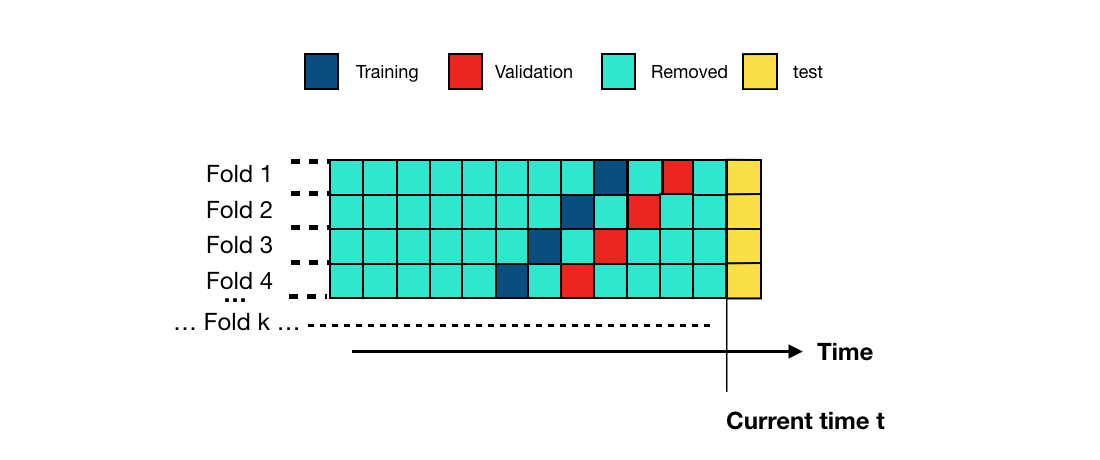
Define prequential_parameters_search function for finding best parameters for each model.

In [211]:
def prequential_parameters_search(transactions_df, 
                            classifier, 
                            input_features, output_feature, 
                            parameters, scoring, 
                            start_date_training, 
                            n_folds=4,
                            expe_type='Test',
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            type_search='grid',
                            n_iter=10,
                            random_state=0,
                            n_jobs=-1):
    #create pipe
    estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
    pipe = sklearn.pipeline.Pipeline(estimators)
    
    #get train and validaion indices using prequential split stratergy(as list of tuples depending on number of folds)
    prequential_split_indices=prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)
    
    parameters_search = None
    #Initialize tuning object
    if type_search=="grid":
        
        parameters_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, 
                                         refit=False, n_jobs=n_jobs)
    
    if type_search=="random":
        
        parameters_search = sklearn.model_selection.RandomizedSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, 
                                     refit=False, n_jobs=n_jobs,n_iter=n_iter,random_state=random_state)

    #Create datasets
    X=transactions_df[input_features]
    y=transactions_df[output_feature]

    #fit 
    parameters_search.fit(X, y)
    
    #Create performance DF and update the result based on the cv_results
    performances_df=pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=parameters_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=parameters_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters']=parameters_search.cv_results_['params']
    performances_df['Execution time']=parameters_search.cv_results_['mean_fit_time']
    
    return performances_df

In [212]:
# For the sake of conciseness, let us define a model_selection_wrapper function, that will perform prequential validation for both the validation and the test sets.

def model_selection_wrapper(transactions_df, 
                            classifier, 
                            input_features, output_feature,
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            start_date_training_for_test,
                            n_folds=4,
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            type_search='grid',
                            n_iter=10,
                            random_state=0,
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation=prequential_parameters_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            type_search=type_search,
                            n_iter=n_iter,
                            random_state=random_state,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test=prequential_parameters_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            type_search=type_search,
                            n_iter=n_iter,
                            random_state=random_state,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df

Prequential validation can now be performed with the few following lines of code, by

- defining which classifier to use
- defining which parameters to test
- fitting the models and assessing the performances

Let's try this validation set up using DT with various depths of [2,5,10,20,50]

In [213]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,5,10,20,50], 'clf__random_state':[0]}

start_time = time.time()


# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        type_search='random',
                                        n_iter=10,
                                        random_state=0,
                                        n_jobs=1)

execution_time_dt = time.time()-start_time


parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']= [parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]


# Rename to performances_df_xgboost_random for model performance comparison
performances_df_dt=performances_df

In [214]:
performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.791909,0.017769,0.541761,0.031476,0.265000,0.019756,"{'clf__random_state': 0, 'clf__max_depth': 2}",0.385725,0.790786,0.012035,0.549767,0.022134,0.256429,0.014481,2
1,0.810138,0.008586,0.600306,0.016797,0.284286,0.004286,"{'clf__random_state': 0, 'clf__max_depth': 5}",0.506768,0.804218,0.016505,0.546094,0.042197,0.267857,0.013869,5
2,0.758138,0.011140,0.504909,0.013154,0.257500,0.010467,"{'clf__random_state': 0, 'clf__max_depth': 10}",0.737361,0.786784,0.031165,0.493543,0.048307,0.257143,0.009949,10
3,0.754024,0.009848,0.439422,0.034828,0.261071,0.014335,"{'clf__random_state': 0, 'clf__max_depth': 20}",1.159343,0.780408,0.022168,0.450980,0.031413,0.264286,0.007890,20
4,0.797225,0.005427,0.334457,0.020767,0.257857,0.011715,"{'clf__random_state': 0, 'clf__max_depth': 50}",1.281015,0.822564,0.013407,0.341818,0.026227,0.265714,0.008512,50


Let us extract from this table the most relevant information, that is, entries that allow to answer the following questions:

- Which parameter provides the best performances on the validation set?
- What is the performances on the test set using this parameter?
- What parameter would have provided the best performance on the test set?
Answers to these questions can be organized as a table, using the get_summary_performances function.

In [226]:
def get_summary_performances(performances_df, parameter_column_name="Parameters summary"):

    # Three performance metrics
    metrics = ['AUC ROC','Average precision','Card Precision@100']
    performances_results=pd.DataFrame(columns=metrics)
    
    # Reset indices in case a subset of a performane DataFrame is provided as input
    performances_df.reset_index(drop=True,inplace=True)

    # Lists of parameters/performances that will be retrieved for the best estimated parameters
    best_estimated_parameters = []
    validation_performance = []
    test_performance = []
    
    # For each performance metric, get the validation and test performance for the best estimated parameter
    for metric in metrics:
    
        # Find the index which provides the best validation performance
        index_best_validation_performance = performances_df.index[np.argmax(performances_df[metric+' Validation'].values)]
    
        # Retrieve the corresponding parameters
        best_estimated_parameters.append(performances_df[parameter_column_name].iloc[index_best_validation_performance])
        
        # Add validation performance to the validation_performance list (mean+/-std)
        validation_performance.append(
                str(round(performances_df[metric+' Validation'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Validation'+' Std'].iloc[index_best_validation_performance],2))
        )
        
        # Add test performance to the test_performance list (mean+/-std)
        test_performance.append(
                str(round(performances_df[metric+' Test'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Test'+' Std'].iloc[index_best_validation_performance],2))
        )
    
    # Add results to the performances_results DataFrame
    performances_results.loc["Best estimated parameters"]=best_estimated_parameters
    performances_results.loc["Validation performance"]=validation_performance
    performances_results.loc["Test performance"]=test_performance

    # Lists of parameters/performances that will be retrieved for the optimal parameters
    optimal_test_performance = []
    optimal_parameters = []

    # For each performance metric, get the performance for the optimal parameter
    for metric in ['AUC ROC Test','Average precision Test','Card Precision@100 Test']:
    
        # Find the index which provides the optimal performance
        index_optimal_test_performance = performances_df.index[np.argmax(performances_df[metric].values)]
    
        # Retrieve the corresponding parameters
        optimal_parameters.append(performances_df[parameter_column_name].iloc[index_optimal_test_performance])
    
        # Add test performance to the test_performance list (mean+/-std)
        optimal_test_performance.append(
                str(round(performances_df[metric].iloc[index_optimal_test_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Std'].iloc[index_optimal_test_performance],2))
        )

    # Add results to the performances_results DataFrame
    performances_results.loc["Optimal parameters"]=optimal_parameters
    performances_results.loc["Optimal test performance"]=optimal_test_performance
    
    return performances_results

In [227]:
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,50,2,5
Validation performance,0.823+/-0.01,0.55+/-0.02,0.268+/-0.01
Test performance,0.797+/-0.01,0.542+/-0.03,0.284+/-0.0
Optimal parameters,5,5,5
Optimal test performance,0.81+/-0.01,0.6+/-0.02,0.284+/-0.0


The first row provides the parameters that maximize the performances on the validation set (best estimated parameters ). The second and third rows provide the corresponding performances on the validation and test sets, respectively. The fourth row provides the actual optimal parameters on the test set (the parameters that maximize the performances on the test set). The fifth row provides the corresponding performances on the test set.

Two important observations can be made from this summary table. First, the optimal parameter depends on the performance metrics: It is a maximum depth of 5 for all metrices. Second, the best parameters for the validation may not be the optimal parameter for the test set. This is the case for the AUC ROC (maximum depth of 50 for the validation set versus 5 for the test set), and the AP (maximum depth of 2 for the validation set versus 5 for the test set).

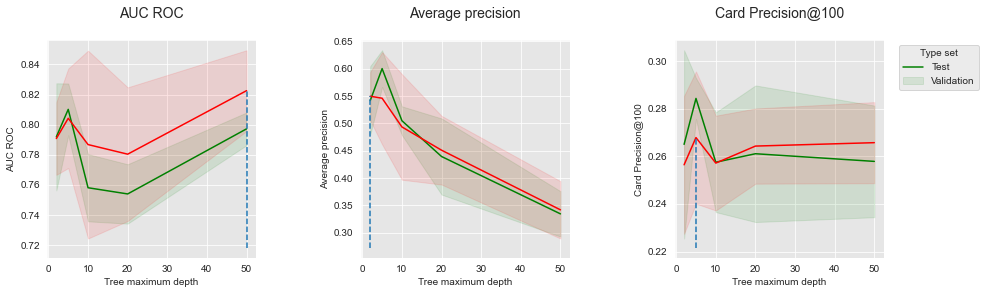

In [228]:
# Let's do a performance plots
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       summary_performances=summary_performances_dt)

Now we'll try with  logistic regression, random forests, and boosting.


###### Logistic Regression

In [229]:
classifier = sklearn.linear_model.LogisticRegression()

parameters = {'clf__C':[0.1,1,10,100], 'clf__random_state':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        type_search='random',
                                        n_iter=10,
                                        random_state=0,
                                        n_jobs=1)


execution_time_lr = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__C'] for i in range(len(parameters_dict))]

# Rename to performances_df_lr for model performance comparison at the end of this notebook
performances_df_lr=performances_df

In [230]:
performances_df_lr


,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.866972,0.014858,0.620231,0.015977,0.297143,0.008207,"{'clf__random_state': 0, 'clf__C': 0.1}",0.521629,0.865052,0.009591,0.608330,0.022740,0.278929,0.016300,0.1
1,0.867643,0.015404,0.623081,0.016204,0.297143,0.008806,"{'clf__random_state': 0, 'clf__C': 1}",0.573451,0.866861,0.008988,0.612264,0.023474,0.278214,0.016914,1.0
2,0.867678,0.015415,0.623224,0.016087,0.297500,0.008828,"{'clf__random_state': 0, 'clf__C': 10}",0.607755,0.867050,0.008918,0.612526,0.023715,0.277500,0.016763,10.0
3,0.867680,0.015419,0.623253,0.016074,0.297500,0.008828,"{'clf__random_state': 0, 'clf__C': 100}",0.623082,0.867071,0.008912,0.612537,0.023712,0.277500,0.016763,100.0


In [231]:
summary_performances_lr=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100.0,100.0,0.1
Validation performance,0.867+/-0.01,0.613+/-0.02,0.279+/-0.02
Test performance,0.868+/-0.02,0.623+/-0.02,0.297+/-0.01
Optimal parameters,100.0,100.0,10.0
Optimal test performance,0.868+/-0.02,0.623+/-0.02,0.298+/-0.01


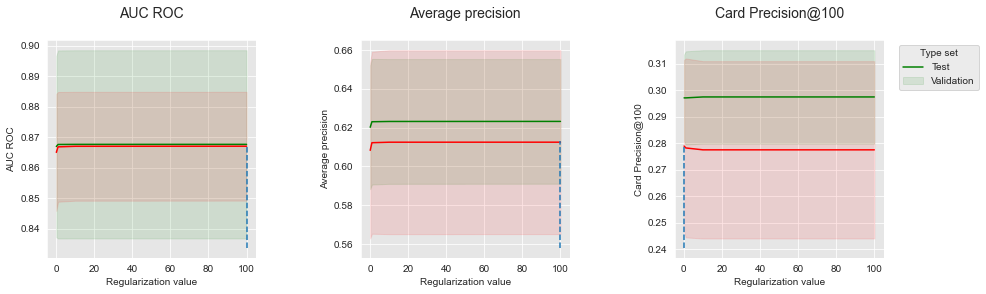

In [232]:
get_performances_plots(performances_df_lr, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Regularization value",
                       summary_performances=summary_performances_lr)


Performances tend to be a bit lower for a low  value (0.1).  values equal or higher than one provide similar performances. The default parameter  seems therefore to be a sensible value for the logistic regression model.

###### Random forest

The two main hyperparameters of a random forest are the maximum tree depth and the number of trees. Let us try other values, by combining max_depth values in the set [5,10,20,50] and n_estimators values in the set [25,50,100].

In [234]:
classifier = sklearn.ensemble.RandomForestClassifier()

# Note: n_jobs set to one for getting true execution times
parameters = {'clf__max_depth':[5,10,20,50], 'clf__n_estimators':[25,50,100],
              'clf__random_state':[0],'clf__n_jobs':[1]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        type_search='random',
                                        n_iter=10,
                                        random_state=0,
                                        n_jobs=1)


execution_time_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_rf for model performance comparison at the end of this notebook
performances_df_rf=performances_df

In [235]:
performances_df_rf

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.853581,0.014851,0.660131,0.013713,0.296429,0.012016,"{'clf__random_state': 0, 'clf__n_jobs': 1, 'cl...",3.154569,0.869824,0.005664,0.680407,0.016981,0.285357,0.014962,25/20
1,0.870256,0.014185,0.671611,0.011290,0.298571,0.013363,"{'clf__random_state': 0, 'clf__n_jobs': 1, 'cl...",12.219285,0.878369,0.002908,0.691405,0.019560,0.287500,0.015199,100/50
2,0.869225,0.007955,0.655050,0.014192,0.300000,0.012495,"{'clf__random_state': 0, 'clf__n_jobs': 1, 'cl...",3.562671,0.871323,0.004542,0.659386,0.021993,0.286786,0.015531,50/10
3,0.865997,0.013420,0.663305,0.009296,0.296071,0.011401,"{'clf__random_state': 0, 'clf__n_jobs': 1, 'cl...",6.038125,0.875154,0.003631,0.683127,0.020882,0.287143,0.015518,50/50
4,0.855230,0.007315,0.627034,0.021852,0.292500,0.010850,"{'clf__random_state': 0, 'clf__n_jobs': 1, 'cl...",3.919715,0.849065,0.011019,0.619450,0.026249,0.275000,0.016614,100/5
5,0.870378,0.016910,0.677675,0.011698,0.299286,0.013190,"{'clf__random_state': 0, 'clf__n_jobs': 1, 'cl...",10.984197,0.879728,0.006367,0.694063,0.020657,0.288571,0.016690,100/20
6,0.850968,0.007508,0.620932,0.023824,0.290714,0.010996,"{'clf__random_state': 0, 'clf__n_jobs': 1, 'cl...",2.162266,0.844140,0.007473,0.609801,0.027459,0.272857,0.015085,50/5
7,0.862653,0.016004,0.673352,0.011485,0.297143,0.013439,"{'clf__random_state': 0, 'clf__n_jobs': 1, 'cl...",6.157825,0.876311,0.006772,0.690434,0.019828,0.287143,0.016506,50/20
8,0.858527,0.008786,0.651899,0.009478,0.296429,0.010996,"{'clf__random_state': 0, 'clf__n_jobs': 1, 'cl...",3.317770,0.869956,0.003717,0.674013,0.021356,0.283929,0.016671,25/50
9,0.867271,0.006166,0.648583,0.012831,0.300714,0.010950,"{'clf__random_state': 0, 'clf__n_jobs': 1, 'cl...",2.129511,0.865000,0.002259,0.651858,0.020059,0.285357,0.012305,25/10


In [236]:
summary_performances_rf=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")
summary_performances_rf

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/20,100/20,100/20
Validation performance,0.88+/-0.01,0.694+/-0.02,0.289+/-0.02
Test performance,0.87+/-0.02,0.678+/-0.01,0.299+/-0.01
Optimal parameters,100/20,100/20,25/10
Optimal test performance,0.87+/-0.02,0.678+/-0.01,0.301+/-0.01


The best performances are obtained with forests containing 100/25 trees, with a maximum depth of 10 or 20. The optimal parameters differ from the best estimated parameters for the AUC and CP@100. The difference in terms of performances is however low, and the best estimated parameters can be considered close to the optimal ones.

The visualization of the performances as a function of the model parameters is trickier since two parameters are varied. Let us first fix the number of trees, and then vary the maximum tree depth.

Fixing the number of trees to 100, we get:

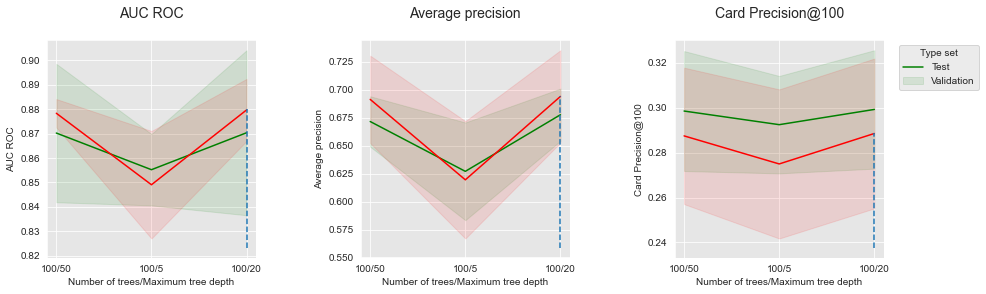

In [237]:
performances_df_rf_fixed_number_of_trees=performances_df_rf[performances_df_rf["Parameters summary"].str.startswith("100")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_rf_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_rf_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)


Only CP@100 has reported an optimal param different as that of best parameters. As there is not much difference in validation and optimal performance 100/20 can be chosen as best parameters for the randomforest.
100 estimators and 20 as max depth.

###### XGBoost
XGBoost is a powerful learning algorithm whose tuning however relies on many hyperparameters. The most important ones are arguably the tree maximum depth (max_depth), the number of trees (n_estimators), and the learning rate (learning_rate). By default, the maximum tree depth is set to 6, the number of trees to 100, and the learning rate to 0.3. Let us try other combinations, with max_depth in the set [3,6,9], n_estimators in the set [25,10,100], and learning_rate in the set [0.1, 0.3].

In [238]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3,6,9], 'clf__n_estimators':[25,50,100], 'clf__learning_rate':[0.1, 0.3],
              'clf__random_state':[0], 'clf__n_jobs':[1], 'clf__verbosity':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        type_search='random',
                                        n_iter=10,
                                        random_state=0,
                                        n_jobs=1)

execution_time_boosting = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_xgboost for model performance comparison at the end of this notebook
performances_df_xgboost=performances_df

In [240]:
performances_df_xgboost


,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.864766,0.006604,0.666130,0.012722,0.301429,0.013439,"{'clf__verbosity': 0, 'clf__random_state': 0, ...",4.241820,0.863627,0.003203,0.651369,0.030279,0.280714,0.014932,50/0.1/3
1,0.852550,0.003171,0.656631,0.012632,0.302857,0.012164,"{'clf__verbosity': 0, 'clf__random_state': 0, ...",4.814458,0.854345,0.008599,0.656910,0.023964,0.281429,0.012817,25/0.1/9
2,0.862519,0.007472,0.674149,0.007838,0.293929,0.012428,"{'clf__verbosity': 0, 'clf__random_state': 0, ...",19.022143,0.879667,0.003782,0.700592,0.017885,0.285000,0.017394,100/0.1/9
3,0.871726,0.010990,0.686534,0.011086,0.302143,0.013458,"{'clf__verbosity': 0, 'clf__random_state': 0, ...",4.241647,0.882839,0.008380,0.708226,0.020697,0.287500,0.016331,50/0.3/3
4,0.859138,0.004852,0.659458,0.012488,0.285357,0.010369,"{'clf__verbosity': 0, 'clf__random_state': 0, ...",14.545063,0.878025,0.007150,0.691442,0.016375,0.279643,0.013567,100/0.3/6
5,0.871589,0.014202,0.686221,0.012026,0.301786,0.009603,"{'clf__verbosity': 0, 'clf__random_state': 0, ...",7.509455,0.869654,0.002863,0.699780,0.016875,0.288214,0.016884,50/0.1/6
6,0.870792,0.012352,0.694030,0.008394,0.303929,0.012305,"{'clf__verbosity': 0, 'clf__random_state': 0, ...",8.465003,0.878438,0.009221,0.705235,0.019756,0.288214,0.015694,100/0.1/3
7,0.859114,0.003609,0.660666,0.008002,0.288214,0.008943,"{'clf__verbosity': 0, 'clf__random_state': 0, ...",10.335135,0.876392,0.006354,0.692759,0.017801,0.280357,0.014441,50/0.3/9
8,0.860454,0.002511,0.658901,0.010897,0.286786,0.009056,"{'clf__verbosity': 0, 'clf__random_state': 0, ...",20.002505,0.879577,0.006008,0.690895,0.016712,0.278571,0.015286,100/0.3/9
9,0.870988,0.014197,0.678544,0.012501,0.303214,0.012592,"{'clf__verbosity': 0, 'clf__random_state': 0, ...",2.338918,0.877231,0.006120,0.698490,0.022835,0.288929,0.015131,25/0.3/3


In [239]:
summary_performances_xgboost=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")
summary_performances_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,50/0.3/3,50/0.3/3,25/0.3/3
Validation performance,0.883+/-0.01,0.708+/-0.02,0.289+/-0.02
Test performance,0.872+/-0.01,0.687+/-0.01,0.303+/-0.01
Optimal parameters,50/0.3/3,100/0.1/3,100/0.1/3
Optimal test performance,0.872+/-0.01,0.694+/-0.01,0.304+/-0.01


The best parameters obtained by validation are the same for ROC AUC, and slightly differ for the average precision and CP@100. The corresponding test performances are however on par.
Let us plot the performances as a function of the maximum tree depth, for a number of trees set to 100. Increasing the maximum tree depth does not clearly affect the performances. It slightly increases performances for AUC ROC , AP and CP@100.

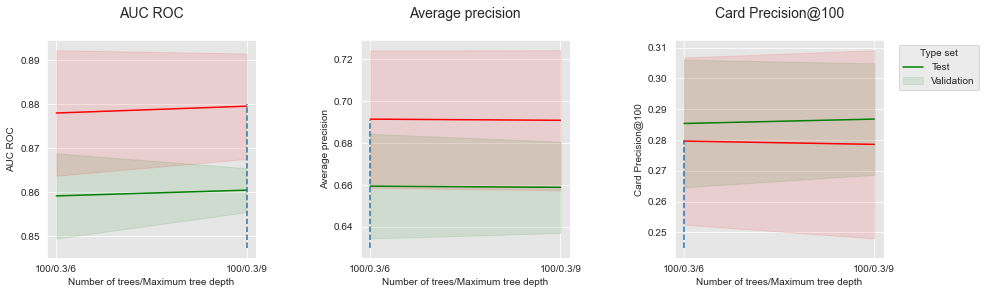

In [241]:
performances_df_xgboost_fixed_number_of_trees=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.startswith("100/0.3")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_xgboost_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)


Let us then plot the performances as a function of the number of trees, for a maximum tree depth set to 3.



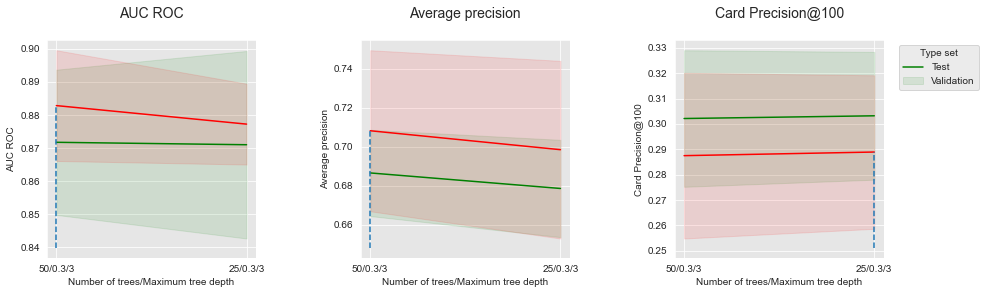

In [242]:
performances_df_xgboost_fixed_max_tree_depth=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.endswith("0.3/3")]

summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_xgboost_fixed_max_tree_depth, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_max_tree_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

Increasing the number of trees from 25 to 50 allow to increase the performances for all performance metrics.

###### Comparison of model performances
The previous section detailed the performances of different model classes. Let us compare these performances in order to determine which model class provides the best performances.

For each model class, let us retrieve the performance for three types of parameters:

- Default parameters: Default parameters that sklearn gives to a model class. The default parameters for each model class are:
 - Logistic regression: C=1.
 - Random forest: n_estimators=100, max_depth=None.
 - XGBoost: n_estimators=100, max_depth=6, learning_rate=0.3.
- Best estimated parameters: Parameters that provide the highest performances on the validation set.
- Optimal parameters: Parameters that provide the highest performances on the test set.
The model_selection_performances function below takes a dictionary of performance DataFrames and a performance metric, and retrieves the corresponding performances (mean together with standard deviation).

In [243]:
performances_df_dictionary={
    "Logistic Regression": performances_df_lr,
    "Random Forest": performances_df_rf,
    "XGBoost": performances_df_xgboost
}

In [244]:
def model_selection_performances(performances_df_dictionary,
                                 performance_metric='AUC ROC',
                                 model_classes=['Logistic Regression', 
                                                'Random Forest', 
                                                'XGBoost'],
                                 default_parameters_dictionary={
                                                "Logistic Regression": 1,
                                                "Random Forest": "100/50",
                                                "XGBoost": "100/0.3/6"
                                            }):
    
    mean_performances_dictionary={
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    std_performances_dictionary={
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    # For each model class
    for model_class in model_classes:
        
        performances_df=performances_df_dictionary[model_class]
        
        # Get the performances for the default paramaters
        default_performances=performances_df[performances_df['Parameters summary']==default_parameters_dictionary[model_class]]
        default_performances=default_performances.round(decimals=3)
        
        mean_performances_dictionary["Default parameters"].append(default_performances[performance_metric+" Test"].values[0])
        std_performances_dictionary["Default parameters"].append(default_performances[performance_metric+" Test Std"].values[0])
        
        # Get the performances for the best estimated parameters
        performances_summary=get_summary_performances(performances_df, parameter_column_name="Parameters summary")
        mean_std_performances=performances_summary.loc[["Test performance"]][performance_metric].values[0]
        mean_std_performances=mean_std_performances.split("+/-")
        mean_performances_dictionary["Best validation parameters"].append(float(mean_std_performances[0]))
        std_performances_dictionary["Best validation parameters"].append(float(mean_std_performances[1]))
        
        # Get the performances for the boptimal parameters
        mean_std_performances=performances_summary.loc[["Optimal test performance"]][performance_metric].values[0]
        mean_std_performances=mean_std_performances.split("+/-")
        mean_performances_dictionary["Optimal parameters"].append(float(mean_std_performances[0]))
        std_performances_dictionary["Optimal parameters"].append(float(mean_std_performances[1]))
        
    # Return the mean performances and their standard deviations    
    return (mean_performances_dictionary,std_performances_dictionary)

In [245]:
model_selection_performances(performances_df_dictionary,
                             performance_metric='AUC ROC')

({'Default parameters': [0.868, 0.87, 0.859],
  'Best validation parameters': [0.868, 0.87, 0.872],
  'Optimal parameters': [0.868, 0.87, 0.872]},
 {'Default parameters': [0.015, 0.014, 0.005],
  'Best validation parameters': [0.02, 0.02, 0.01],
  'Optimal parameters': [0.02, 0.02, 0.01]})

For better visualization, let us plot the performances for the four model classes and for each performance metric as bar charts. The implementation is provided with the get_model_selection_performance_plot and get_model_selection_performances_plots below.

In [249]:
# Get the performance plot for a single performance metric
def get_model_selection_performance_plot(performances_df_dictionary, 
                                         ax, 
                                         performance_metric,
                                         ylim=[0,1],
                                         model_classes=['Logistic Regression', 
                                                        'Random Forest', 
                                                        'XGBoost']):
    
    
    (mean_performances_dictionary,std_performances_dictionary) = \
        model_selection_performances(performances_df_dictionary=performances_df_dictionary,
                                     performance_metric=performance_metric)
    
    
    # width of the bars
    barWidth = 0.3
    # The x position of bars
    r1 = np.arange(len(model_classes))
    r2 = r1+barWidth
    r3 = r1+2*barWidth
    
    # Create Default parameters bars (Orange)
    ax.bar(r1, mean_performances_dictionary['Default parameters'], 
           width = barWidth, color = '#CA8035', edgecolor = 'black', 
           yerr=std_performances_dictionary['Default parameters'], capsize=7, label='Default parameters')
 
    # Create Best validation parameters bars (Red)
    ax.bar(r2, mean_performances_dictionary['Best validation parameters'], 
           width = barWidth, color = '#008000', edgecolor = 'black', 
           yerr=std_performances_dictionary['Best validation parameters'], capsize=7, label='Best validation parameters')

    # Create Optimal parameters bars (Green)
    ax.bar(r3, mean_performances_dictionary['Optimal parameters'], 
           width = barWidth, color = '#2F4D7E', edgecolor = 'black', 
           yerr=std_performances_dictionary['Optimal parameters'], capsize=7, label='Optimal parameters')
 

    # Set title, and x and y axes labels
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xticks(r2+barWidth/2)
    ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
    ax.set_title(performance_metric+'\n', fontsize=18)
    ax.set_xlabel("Model class", fontsize=16)
    ax.set_ylabel(performance_metric, fontsize=15)

In [250]:
def get_model_selection_performances_plots(performances_df_dictionary, 
                                           performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'],
                                           ylim_list=[[0.6,0.9],[0.2,0.8],[0.2,0.35]],
                                           model_classes=['Logistic Regression', 
                                                          'Random Forest', 
                                                          'XGBoost']):
    
    # Create as many graphs as there are performance metrics to display
    n_performance_metrics = len(performance_metrics_list)
    fig, ax = plt.subplots(1, n_performance_metrics, figsize=(5*n_performance_metrics,4))
    
    parameter_types=['Default parameters','Best validation parameters','Optimal parameters']
    
    # Plot performance metric for each metric in performance_metrics_list
    for i in range(n_performance_metrics):
    
        get_model_selection_performance_plot(performances_df_dictionary, 
                                             ax[i], 
                                             performance_metrics_list[i],
                                             ylim=ylim_list[i],
                                             model_classes=model_classes
                                            )
    
    ax[n_performance_metrics-1].legend(loc='upper left', 
                                       labels=parameter_types, 
                                       bbox_to_anchor=(1.05, 1),
                                       title="Parameter type",
                                       prop={'size': 12},
                                       title_fontsize=12)

    plt.subplots_adjust(wspace=0.5, 
                        hspace=0.8)

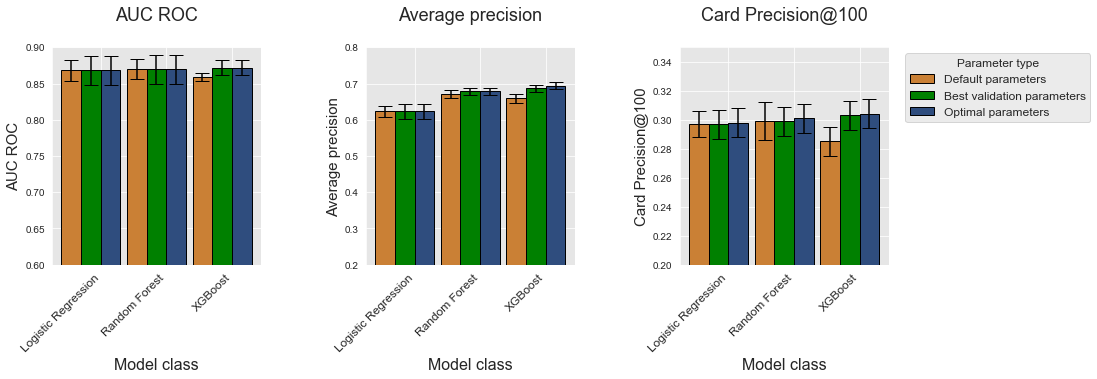

In [252]:
get_model_selection_performances_plots(performances_df_dictionary, 
                                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'])

On this simulated dataset, XGBoost provides the highest performances in terms of Average Precision and CP@100, followed by random forest and logistic regression. The gap in terms of performance is most visible with the average precision metric. The performances of logistic regression, random forest, and XGBoost are very similar in terms of AUC ROC.